In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Importacion de datos de entrenamiento
df = pd.read_excel('data_entrenada_propia_GP.ods', engine='odf')
df

,Unnamed: 0,feedback,codigo,polaridad,Unnamed: 4
0,624927,"muy bien elaborada, se podría incluir ciertos ...",624927,P,NaN
1,543337,La información es ordenada y precisa pero reco...,543337,P,NaN
2,614284,Excelente aporte,614284,P,NaN
3,296130,"En la respuesta que le he puesto 3, ha sido po...",296130,N,NaN
4,555037,"Conciso, excelente",555037,P,NaN
...,...,...,...,...,...
2995,684953,excelente,684953,P,NaN
2996,444203,"Felicidades estimado/a estudiante, excelente t...",444203,P,NaN
2997,666824,Me gusto su presentación,666824,P,NaN
2998,167032,Se entiende en la formulacion de la encuesta q...,167032,P,NaN


In [57]:
df2 = pd.read_csv('Dataset_de_Pruebas_Extendido.csv')
df2

,feedback,polaridad
0,"La experiencia fue excelente, muy recomendada",P
1,"Nunca recibí lo que pedí, pésimo servicio",N
2,No tengo nada relevante que mencionar,NEU
3,Definitivamente lo volvería a comprar,P
4,El paquete estaba incompleto y defectuoso,N
...,...,...
2996,"La experiencia fue regular, ni buena ni mala",NEU
2997,El equipo funciona perfectamente,P
2998,La atención fue deficiente y no cumplieron lo ...,N
2999,"Podría ser mejor, pero no es terrible",NEU


# Limpieza de datos

In [3]:
print(df.isnull().sum())

Unnamed: 0       0
feedback         5
codigo           0
polaridad        7
Unnamed: 4    2792
dtype: int64


In [4]:
# Eliminar filas con valores nulos en 'feedback' o 'polaridad'
df = df.dropna(subset=['feedback', 'polaridad'])

In [5]:
# Verificar que los valores nulos se eliminaron
print(df.isnull().sum())

Unnamed: 0       0
feedback         0
codigo           0
polaridad        0
Unnamed: 4    2780
dtype: int64


In [6]:
# DataFrame solo con las columnas necesarias
df = df[['polaridad', 'feedback']]

In [7]:
# Revision de la columna 'polaridad'
print(df['polaridad'].value_counts())

polaridad
P         1780
N          552
NEU        330
NONE       322
NUE          2
NEUTRO       1
NOE          1
Name: count, dtype: int64


In [8]:
# Normalizar los nombres de la polaridad
df.loc[(df['polaridad'] == 'NEUTRO') | (df['polaridad'] == 'NUE') | (df['polaridad'] == 'NOE')]

,polaridad,feedback
68,NEUTRO,Muy Bien
253,NUE,Hay variedad de plantas que son medicinales de...
1331,NOE,10 puntos.
1446,NUE,Muy narrativa


In [9]:
# Cambiar valores incorrectos
df.loc[:, 'polaridad'] = df['polaridad'].replace({
    'NEUTRO': 'P',
    'NOE': 'NONE',
    'NUE': 'NEU'
})

In [10]:
# Revision de los cambios en la columna 'polaridad'
print(df['polaridad'].value_counts())

polaridad
P       1781
N        552
NEU      332
NONE     323
Name: count, dtype: int64


In [11]:
df['feedback'] = df['feedback'].astype(str)

In [12]:
df.head()

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"


In [13]:
# Eliminar los datos NONE que no tienen ningun valor
df = df[df['polaridad'] != 'NONE']

In [69]:
# Concatenar los datasets por filas
df = pd.concat([df, df2], ignore_index=True)

# Mostrar el resultado
df

,polaridad,feedback
0,P,"muy bien elaborada, se podría incluir ciertos ..."
1,P,La información es ordenada y precisa pero reco...
2,P,Excelente aporte
3,N,"En la respuesta que le he puesto 3, ha sido po..."
4,P,"Conciso, excelente"
...,...,...
5661,NEU,"La experiencia fue regular, ni buena ni mala"
5662,P,El equipo funciona perfectamente
5663,N,La atención fue deficiente y no cumplieron lo ...
5664,NEU,"Podría ser mejor, pero no es terrible"


<Axes: >

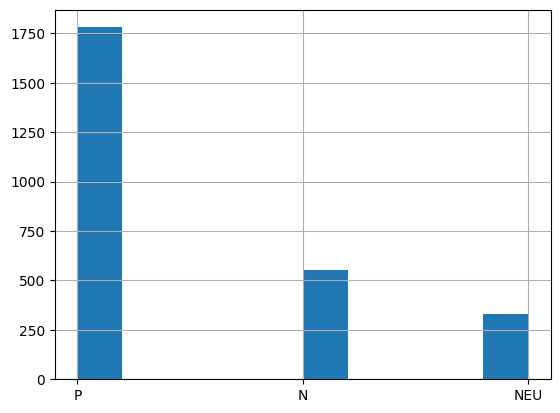

In [14]:
df['polaridad'].hist()

In [45]:
# Crear codigos para cada polaridad
target_map = {'P': 1, 'N': 0, 'NEU': 2}
df['target'] = df['polaridad'].map(target_map)

In [46]:
df

,polaridad,feedback,target
0,P,"muy bien elaborada, se podría incluir ciertos ...",1
1,P,La información es ordenada y precisa pero reco...,1
2,P,Excelente aporte,1
3,N,"En la respuesta que le he puesto 3, ha sido po...",0
4,P,"Conciso, excelente",1
...,...,...,...
2995,P,excelente,1
2996,P,"Felicidades estimado/a estudiante, excelente t...",1
2997,P,Me gusto su presentación,1
2998,P,Se entiende en la formulacion de la encuesta q...,1


# Entrenamiento del Modelo

In [47]:
# Division de datos para entrenamiento y prueba
train_text, test_text, train_labels, test_labels = train_test_split(df['feedback'], df['target'], test_size=0.4)

In [51]:
print(train_text.shape)
print(train_labels.shape)

(1599,)
(1599,)


In [52]:
print(test_text.shape)
print(test_labels.shape)

(1066,)
(1066,)


In [53]:
# Tienes que descargarte las stopwords primero via nltk.download()
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation

spanish_stopwords = stopwords.words('spanish')
stemmer = SnowballStemmer('spanish')

non_words = list(punctuation)
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize2(text):
    text = ''.join([c for c in text if c not in non_words])
    tokens =  word_tokenize(text)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

In [55]:
# Vectorizacion de palabras 
real_vectorizer = CountVectorizer(tokenizer=tokenize2, binary=True, stop_words=stopwords.words('spanish'))
# real_vectorizer = CountVectorizer(binary=True)
train_X = real_vectorizer.fit_transform(train_text)
test_X = real_vectorizer.transform(test_text)

In [57]:
model = LogisticRegression(max_iter=1000)
model.fit(train_X, train_labels)
print("Train acc: ", model.score(train_X, train_labels))
print("Test acc: ", model.score(test_X, test_labels))

Train acc:  0.9649781113195748
Test acc:  0.7861163227016885


In [59]:
P_train = model.predict(train_X)
P_test = model.predict(test_X)

In [60]:
cm = confusion_matrix(y_train, P_train, normalize='true')
cm

array([[0.18991098, 0.70919881, 0.10089021],
       [0.21126761, 0.69671362, 0.09201878],
       [0.23350254, 0.63959391, 0.12690355]])

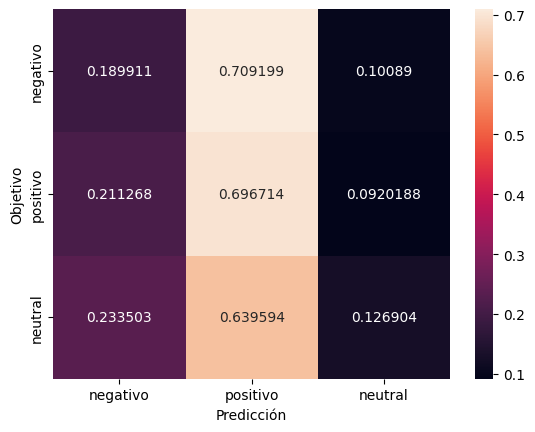

In [61]:
def plot_cm(cm):
    classes = ['negativo', 'positivo', 'neutral']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Objetivo")

plot_cm(cm)

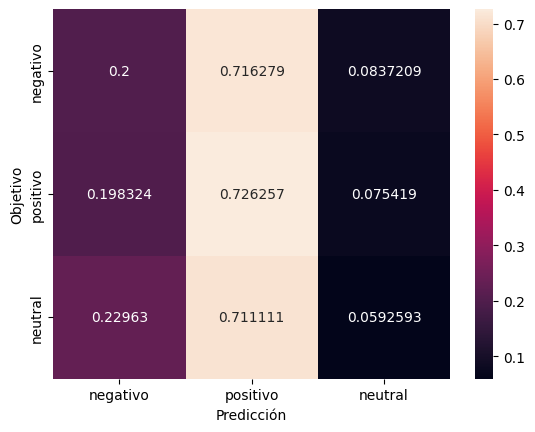

In [62]:
cm = confusion_matrix(y_test, P_test, normalize='true')
plot_cm(cm)

In [64]:
word_index_map = real_vectorizer.vocabulary_
word_index_map

{'provinci': 1263,
 'rios': 1366,
 'realiz': 1300,
 'feri': 699,
 'emprend': 545,
 'buen': 161,
 'present': 1223,
 'compañer': 267,
 'parec': 1130,
 'person': 1159,
 'respond': 1346,
 'pregunt': 1219,
 'form': 720,
 'concis': 298,
 'adem': 25,
 'hab': 765,
 'contest': 336,
 'tod': 1511,
 'interrog': 873,
 'mism': 1024,
 'aportefelicit': 90,
 'felic': 690,
 'correccion': 355,
 'ortograf': 1116,
 'contigüidadbu': 339,
 'trabaj': 1517,
 'excelent': 651,
 'infograf': 844,
 'explic': 665,
 'mas': 977,
 'grafic': 752,
 'palabr': 1123,
 'entiend': 566,
 'perfect': 1154,
 'ide': 806,
 'innov': 859,
 'usted': 1557,
 'tien': 1504,
 'clar': 230,
 'postur': 1207,
 'interes': 870,
 'intervinient': 878,
 'conflict': 307,
 'deb': 405,
 'ser': 1401,
 'respuest': 1348,
 'cas': 207,
 'requier': 1337,
 'mayor': 985,
 'detall': 450,
 'par': 1126,
 'pod': 1188,
 'entend': 564,
 'maner': 967,
 'correct': 356,
 'general': 739,
 'plant': 1174,
 'desd': 443,
 'perspect': 1162,
 'bien': 150,
 'estuv': 637,
 'vi

In [65]:
model.coef_[0]

array([-0.00596591, -0.14537599,  0.07458052, ..., -0.00732317,
       -0.00732317, -0.0030385 ])

In [66]:
corte = 0.8

print("Palabras más positivas:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight > corte:
        print(word, weight)

Palabras más positivas:
falt 0.8278214267939838
visualiz 1.243297650680293
bibliograf 1.03371891417024
sub 1.0470999361570208
tare 1.0426925910955729
color 0.977783445579623
ningun 1.3071334961109413
incomplet 0.831057617081539
posicion 0.837280665519974
document 1.0181562778795874
copi 0.8744195930586554
muestr 1.0395436419511368


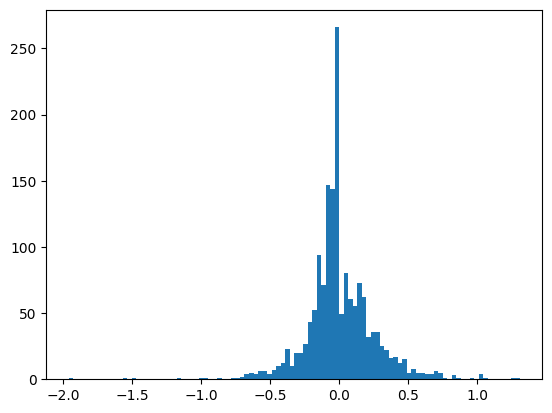

In [67]:
plt.hist(model.coef_[0], bins=100);

In [69]:
corte = 0.7

print("Palabras más positivas:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -corte:
        print(word, weight)

Palabras más positivas:
buen -1.9607179011126294
form -0.7083263213520314
tod -0.7422506890418802
felic -0.870008991321927
excelent -1.4971290676565276
clar -1.0011159032835972
bien -1.539699499327719
felicit -0.962807222142324
bastant -0.7604142290228653
ok -1.1587306004643676
pid -0.7162770050251099


In [88]:
# Prueba del modelo entrenado
prueba = ["Estuvo muy buena la pelicula", "estuvo terrible la pelicula, me aburrí mucho", "no la recomiendo", "Vi la pelicula", "excelente película", "mal trabajo", "mal"]

In [89]:
# Transformar la entrada con el vectorizador
X = real_vectorizer.transform(prueba)

# Predecir con el modelo
P = model.predict(X)
print(P)

[1 1 1 1 1 1 1]
